# Machine Translation + Attention (Sanskrit to English)

In [100]:
import math
import time
import random
import os
import re
from typing import List, Tuple
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt

In [101]:
# !pip uninstall -y torch torchtext torchvision
# !pip install torch==2.3.1 torchtext==0.18.0 torchvision==0.18.1
# !pip install indic-nlp-library spacy
# !python -m spacy download en_core_web_sm
# !pip install tqdm transformers datasets huggingface_hub

In [102]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch, torchtext
from torch.utils.data import DataLoader

In [103]:
torch.__version__
torchtext.__version__

'0.18.0'

In [104]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
device

device(type='mps')

In [105]:
# Set seeds for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## 1. ETL: Loading the dataset

In [106]:
from huggingface_hub import login
import os

# Login is optional for public datasets; use env var if available
hf_token = os.getenv("HUGGINGFACE_HUB_TOKEN") or os.getenv("HF_TOKEN")
if hf_token:
    login(token=hf_token)

In [107]:
from datasets import load_dataset

dataset = load_dataset("acomquest/Saamayik")

train_data = dataset['train']
val_data   = dataset['validation']
test_data  = dataset['test']

### Task 1 — Dataset Preparation
We use the **Saamayik** Sanskrit–English parallel corpus from Hugging Face.
Credits: `acomquest/Saamayik` dataset on Hugging Face 🤗 Datasets.

**Normalization & Filtering**:
- English is lowercased and extra whitespace is removed.
- Sanskrit text is kept in Devanagari; only whitespace is normalized.
- Examples longer than a max token threshold are filtered to stabilize training.

In [108]:
MAX_LEN = 60

def normalize_sa(text: str) -> str:
    text = re.sub(r"\s+", " ", text).strip()
    return text

def normalize_en(text: str) -> str:
    text = re.sub(r"\s+", " ", text).strip().lower()
    return text

def normalize_example(example):
    example["translation"]["sa"] = normalize_sa(example["translation"]["sa"])
    example["translation"]["en"] = normalize_en(example["translation"]["en"])
    return example

def length_filter(example):
    sa_len = len(example["translation"]["sa"].split())
    en_len = len(example["translation"]["en"].split())
    return sa_len <= MAX_LEN and en_len <= MAX_LEN

train_data = train_data.map(normalize_example)
val_data = val_data.map(normalize_example)
test_data = test_data.map(normalize_example)

train_data = train_data.filter(length_filter)
val_data = val_data.filter(length_filter)
test_data = test_data.filter(length_filter)

print("Filtered sizes:", len(train_data), len(val_data), len(test_data))

Filtered sizes: 43474 2416 2417


In [109]:
example = train_data[0]
example

{'translation': {'en': '"save it with ctrl, s."',
  'sa': '"Ctrl, S नुत्वा रक्षन्तु।"'},
 'source': 'main'}

In [110]:
example['translation']['sa']

'"Ctrl, S नुत्वा रक्षन्तु।"'

In [111]:
example['translation']['en']

'"save it with ctrl, s."'

## 2. EDA - simple investigation

#### Fast Statistical Analysis

In [112]:
src_sentences = [x['translation']['sa'] for x in train_data]
trg_sentences = [x['translation']['en'] for x in train_data]

#### Token Length

In [113]:
src_lengths = [len(s.split()) for s in src_sentences]
trg_lengths = [len(s.split()) for s in trg_sentences]

In [114]:
print("Sanskrit Sentence Stats")
print("Mean:", np.mean(src_lengths))
print("Median:", np.median(src_lengths))
print("Max:", np.max(src_lengths))

Sanskrit Sentence Stats
Mean: 9.661590835901919
Median: 9.0
Max: 54


In [115]:
print("\nEnglish Sentence Stats")
print("Mean:", np.mean(trg_lengths))
print("Median:", np.median(trg_lengths))
print("Max:", np.max(trg_lengths))


English Sentence Stats
Mean: 12.688710493628376
Median: 11.0
Max: 60


#### Plot Distribution (Sentence Length Visualization)

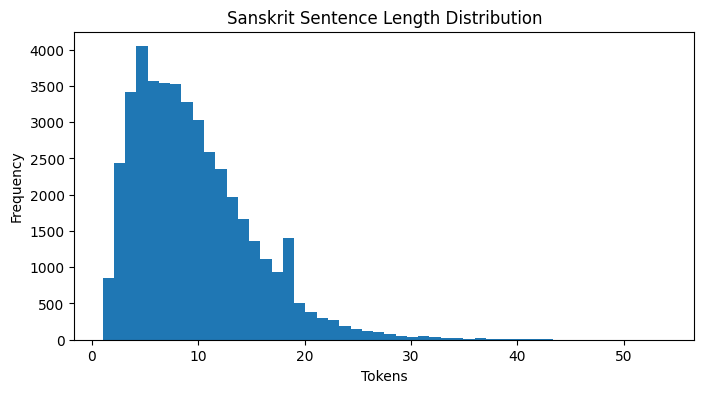

In [116]:
# For Sanskrit
plt.figure(figsize=(8,4))
plt.hist(src_lengths, bins=50)
plt.title("Sanskrit Sentence Length Distribution")
plt.xlabel("Tokens")
plt.ylabel("Frequency")
plt.show()

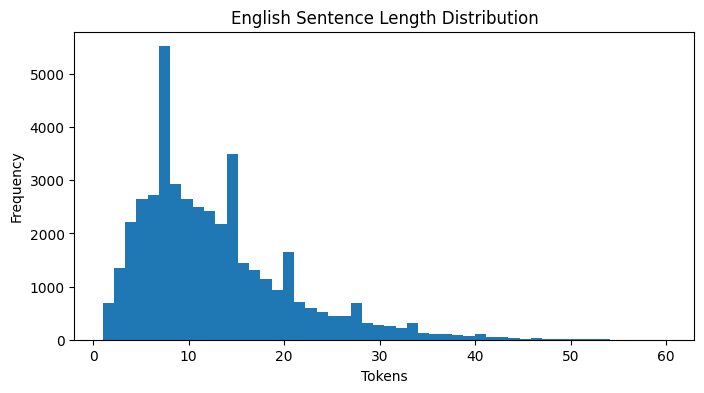

In [117]:
# For English
plt.figure(figsize=(8,4))
plt.hist(trg_lengths, bins=50)
plt.title("English Sentence Length Distribution")
plt.xlabel("Tokens")
plt.ylabel("Frequency")
plt.show()

#### Broken Sentences

In [118]:
empty_src = sum(1 for s in src_sentences if len(s.strip()) == 0)
empty_trg = sum(1 for s in trg_sentences if len(s.strip()) == 0)

print("Empty Sanskrit sentences:", empty_src)
print("Empty English sentences:", empty_trg)

Empty Sanskrit sentences: 0
Empty English sentences: 0


#### Vocabulary Diversity

In [119]:
src_vocab = set(" ".join(src_sentences).split())
trg_vocab = set(" ".join(trg_sentences).split())

print("Unique Sanskrit tokens:", len(src_vocab))
print("Unique English tokens:", len(trg_vocab))

Unique Sanskrit tokens: 98621
Unique English tokens: 43526


#### Character-Level Inspection
##### Sanskrit uses Devanagari Unicode, so verify encoding consistency.

In [120]:
print(src_sentences[0])
print([hex(ord(c)) for c in src_sentences[0][:20]])

"Ctrl, S नुत्वा रक्षन्तु।"
['0x22', '0x43', '0x74', '0x72', '0x6c', '0x2c', '0x20', '0x53', '0x20', '0x928', '0x941', '0x924', '0x94d', '0x935', '0x93e', '0x20', '0x930', '0x915', '0x94d', '0x937']


#### Length Ratio (Alignment Quality Check)

In [121]:
length_ratio = np.mean([
    s_len / t_len if t_len > 0 else 0
    for s_len, t_len in zip(src_lengths, trg_lengths)
])

print("Average Length Ratio (SA/EN):", length_ratio)

Average Length Ratio (SA/EN): 0.8412169665985382


#### Outlier Detection

In [122]:
max_allowed = MAX_LEN

filtered_pairs = [
    (s,t) for s,t in zip(src_sentences, trg_sentences)
    if len(s.split()) < max_allowed and len(t.split()) < max_allowed
]

print("Original pairs:", len(src_sentences))
print("Filtered pairs:", len(filtered_pairs))

Original pairs: 43474
Filtered pairs: 43473


## 3. Preprocessing

### Tokenizing
- Sanskrit: Indic NLP Library (`indic-nlp-library`).
- English: spaCy (`en_core_web_sm`), with a basic fallback.

In [123]:
from indicnlp.tokenize import indic_tokenize
from torchtext.data.utils import get_tokenizer

SRC_LANGUAGE = 'sa'
TRG_LANGUAGE = 'en'

token_transform = {}

# Sanskrit: Indic NLP tokenizer + normalization
token_transform[SRC_LANGUAGE] = lambda x: indic_tokenize.trivial_tokenize(normalize_sa(x))

# English: spaCy tokenizer if available; fallback to basic
try:
    _spacy_en = get_tokenizer('spacy', language='en_core_web_sm')
    token_transform[TRG_LANGUAGE] = lambda x: _spacy_en(normalize_en(x))
except Exception:
    basic_en = get_tokenizer('basic_english')
    token_transform[TRG_LANGUAGE] = lambda x: basic_en(normalize_en(x))

### Vocabulary

In [124]:
from torchtext.vocab import build_vocab_from_iterator

UNK_IDX = 0
PAD_IDX = 1
SOS_IDX = 2
EOS_IDX = 3

special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

#### Yield Tokens

In [125]:
def yield_tokens(data_iter, language):

    for item in data_iter:

        yield token_transform[language](
            item['translation'][language]
        )

#### Build Vocabularies

In [126]:
vocab_transform = {}

for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:

    vocab_transform[ln] = build_vocab_from_iterator(
        yield_tokens(train_data, ln),
        min_freq=2,
        specials=special_symbols,
        special_first=True
    )

    vocab_transform[ln].set_default_index(UNK_IDX)

#### Inspect Vocabulary Size

In [149]:
print("Sanskrit vocab:", len(vocab_transform[SRC_LANGUAGE]))
print("English vocab :", len(vocab_transform[TRG_LANGUAGE]))

Sanskrit vocab: 26390
English vocab : 11905


In [150]:
import pickle

with open("vocab_transform.pkl", "wb") as f:
    pickle.dump(vocab_transform, f)

print("Saved vocab_transform.pkl")

Saved vocab_transform.pkl


## Text Transform Pipeline

#### Sequential Transform

In [128]:
import torch

def sequential_transforms(*transforms):

    def func(txt):

        for transform in transforms:
            txt = transform(txt)

        return txt

    return func

In [129]:
def tensor_transform(token_ids):

    return torch.cat((
        torch.tensor([SOS_IDX]),
        torch.tensor(token_ids),
        torch.tensor([EOS_IDX])
    ))

#### Build Text Transform

In [130]:
text_transform = {}

for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:

    text_transform[ln] = sequential_transforms(
        token_transform[ln],
        vocab_transform[ln],
        tensor_transform
    )

## Collate Function

In [131]:
from torch.nn.utils.rnn import pad_sequence

def collate_batch(batch):
    src_batch, trg_batch = [], []

    for item in batch:
        src = item['translation']['sa']
        trg = item['translation']['en']

        src_batch.append(text_transform[SRC_LANGUAGE](src))
        trg_batch.append(text_transform[TRG_LANGUAGE](trg))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX)

    return src_batch.to(device), trg_batch.to(device)

## DataLoader

In [132]:
BATCH_SIZE = 32

train_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_batch
)

valid_loader = DataLoader(
    val_data,
    batch_size=BATCH_SIZE,
    collate_fn=collate_batch
)

## Model Dimensions

In [133]:
INPUT_DIM  = len(vocab_transform[SRC_LANGUAGE])
OUTPUT_DIM = len(vocab_transform[TRG_LANGUAGE])

ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM     = 512
DROPOUT     = 0.5

## Encoding

In [134]:
class Encoder(nn.Module):

    def __init__(self, input_dim, emb_dim, hid_dim, dropout):
        super().__init__()

        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.GRU(emb_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):

        embedded = self.dropout(self.embedding(src))
        outputs, hidden = self.rnn(embedded)

        return outputs, hidden

### Task 2 — Attention Mechanisms
We implement two attention mechanisms with the following equations:

**General Attention**: $$e_i = s^T h_i$$
**Additive Attention**: $$e_i = v^T \tanh(W_1 h_i + W_2 s)$$

## General Attention

In [135]:
class GeneralAttention(nn.Module):
    """General (dot) attention: e_i = s^T h_i"""

    def __init__(self):
        super().__init__()

    def forward(self, hidden, encoder_outputs):
        # hidden: (batch, hid_dim)
        # encoder_outputs: (src_len, batch, hid_dim)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)  # (batch, src_len, hid_dim)
        energy = torch.bmm(encoder_outputs, hidden.unsqueeze(2)).squeeze(2)  # (batch, src_len)
        return F.softmax(energy, dim=1)

## Additive Attention

In [136]:
class AdditiveAttention(nn.Module):
    """Additive attention: e_i = v^T tanh(W1 h_i + W2 s)"""

    def __init__(self, hid_dim):
        super().__init__()

        self.W1 = nn.Linear(hid_dim, hid_dim, bias=False)
        self.W2 = nn.Linear(hid_dim, hid_dim, bias=False)
        self.v = nn.Linear(hid_dim, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
        # hidden: (batch, hid_dim)
        # encoder_outputs: (src_len, batch, hid_dim)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)  # (batch, src_len, hid_dim)
        hidden = hidden.unsqueeze(1)  # (batch, 1, hid_dim)

        energy = torch.tanh(self.W1(encoder_outputs) + self.W2(hidden))
        attention = self.v(energy).squeeze(2)  # (batch, src_len)
        return F.softmax(attention, dim=1)

## Decoder

In [137]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention

        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.GRU(hid_dim + emb_dim, hid_dim)
        self.fc_out = nn.Linear(hid_dim + hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, encoder_outputs):
        # input: (batch,)
        # hidden: (1, batch, hid_dim)
        # encoder_outputs: (src_len, batch, hid_dim)
        input = input.unsqueeze(0)  # (1, batch)
        embedded = self.dropout(self.embedding(input))  # (1, batch, emb_dim)

        attn_weights = self.attention(hidden.squeeze(0), encoder_outputs)  # (batch, src_len)
        attn_weights = attn_weights.unsqueeze(1)  # (batch, 1, src_len)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)  # (batch, src_len, hid_dim)
        context = torch.bmm(attn_weights, encoder_outputs).squeeze(1)  # (batch, hid_dim)
        context = context.unsqueeze(0)  # (1, batch, hid_dim)

        rnn_input = torch.cat((embedded, context), dim=2)  # (1, batch, emb_dim + hid_dim)
        output, hidden = self.rnn(rnn_input, hidden)

        prediction = self.fc_out(
            torch.cat((output.squeeze(0), context.squeeze(0), embedded.squeeze(0)), dim=1)
        )

        return prediction, hidden, attn_weights.squeeze(1)

## Seq2Seq Wrapper

In [138]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        vocab_size = self.decoder.output_dim

        outputs = torch.zeros(trg_len, batch_size, vocab_size).to(self.device)

        encoder_outputs, hidden = self.encoder(src)
        input = trg[0, :]

        for t in range(1, trg_len):
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs)
            outputs[t] = output

            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1

        return outputs

## Initialization

In [139]:
attn_general = GeneralAttention()
attn_additive = AdditiveAttention(HID_DIM)

model_general = Seq2Seq(
    Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, DROPOUT),
    Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, DROPOUT, attn_general),
    device
).to(device)

model_additive = Seq2Seq(
    Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, DROPOUT),
    Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, DROPOUT, attn_additive),
    device
).to(device)

In [140]:
MODEL_DIR = "models"
os.makedirs(MODEL_DIR, exist_ok=True)

## Training

In [141]:
optimizer_general = optim.Adam(model_general.parameters(), lr=1e-3, weight_decay=1e-4)
optimizer_additive = optim.Adam(model_additive.parameters(), lr=1e-3, weight_decay=1e-4)

# label_smoothing raises train loss slightly and improves generalization
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX, label_smoothing=0.2)

In [142]:
from tqdm.auto import tqdm

def apply_word_dropout(batch, drop_prob=0.3):
    if drop_prob <= 0:
        return batch
    mask = (torch.rand_like(batch.float()) < drop_prob)
    mask = mask & (batch != PAD_IDX) & (batch != SOS_IDX) & (batch != EOS_IDX)
    dropped = batch.clone()
    dropped[mask] = UNK_IDX
    return dropped

def train(model, loader, optimizer, teacher_forcing_ratio=0.5, word_dropout=0.3, l2_lambda=1e-5):
    model.train()
    epoch_loss = 0

    progress_bar = tqdm(loader, desc="Training", leave=False)

    for src, trg in progress_bar:
        optimizer.zero_grad()

        src_noisy = apply_word_dropout(src, word_dropout)
        output = model(src_noisy, trg, teacher_forcing_ratio)

        output_dim = output.shape[-1]
        output = output[1:].reshape(-1, output_dim)
        trg = trg[1:].reshape(-1)

        ce_loss = criterion(output, trg)
        l2_penalty = sum(p.pow(2).sum() for p in model.parameters())
        loss = ce_loss + l2_lambda * l2_penalty

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    return epoch_loss / len(loader)

#### Evaluation Functions

In [157]:
from torchtext.data.metrics import bleu_score

PUNCT_TOKENS = {".", ",", "!", "?", ":", ";", "\"", "''", "``"}

def token_ids(tokens, vocab):
    stoi = vocab.get_stoi()
    return [stoi[t] for t in tokens if t in stoi]

PUNCT_IDS = set(token_ids(PUNCT_TOKENS, vocab_transform[TRG_LANGUAGE]))

def numericalize_src(sentence: str):
    tokens = token_transform[SRC_LANGUAGE](sentence)
    ids = [SOS_IDX] + vocab_transform[SRC_LANGUAGE](tokens) + [EOS_IDX]
    tensor = torch.tensor(ids, dtype=torch.long).unsqueeze(1).to(device)
    return tokens, tensor

def _decode_step(output, step, min_len, min_content_len, repeat_penalty, banned_ids, prev_ids):
    if step < min_len:
        output[0, EOS_IDX] = float("-inf")
    if step < min_content_len:
        for pid in PUNCT_IDS.union(banned_ids):
            output[0, pid] = float("-inf")
    if repeat_penalty > 1.0:
        for pid in set(prev_ids):
            output[0, pid] /= repeat_penalty
    if prev_ids:
        output[0, prev_ids[-1]] = float("-inf")
    return output

def translate_with_attention(
    sentence: str,
    model,
    max_len: int = 50,
    min_len: int = 2,
    min_content_len: int = 2,
    repeat_penalty: float = 1.2,
    banned_ids: set = None
 ):
    model.eval()
    src_tokens, src_tensor = numericalize_src(sentence)

    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor)

    trg_indexes = [SOS_IDX]
    attentions = []
    banned_ids = banned_ids or set()

    for step in range(max_len):
        trg_tensor = torch.tensor([trg_indexes[-1]], device=device)
        with torch.no_grad():
            output, hidden, attn = model.decoder(trg_tensor, hidden, encoder_outputs)
        output = _decode_step(output, step, min_len, min_content_len, repeat_penalty, banned_ids, trg_indexes)
        pred_token = output.argmax(1).item()
        trg_indexes.append(pred_token)
        attentions.append(attn.squeeze(0).cpu().numpy())
        if pred_token == EOS_IDX:
            break

    trg_tokens = vocab_transform[TRG_LANGUAGE].lookup_tokens(trg_indexes)
    return trg_tokens, np.array(attentions), src_tokens

def beam_search_translate(
    sentence: str,
    model,
    max_len: int = 50,
    min_len: int = 2,
    min_content_len: int = 2,
    repeat_penalty: float = 1.2,
    banned_ids: set = None,
    beam_size: int = 6,
    length_penalty: float = 0.9,
 ):
    model.eval()
    src_tokens, src_tensor = numericalize_src(sentence)

    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor)

    banned_ids = banned_ids or set()
    beams = [([SOS_IDX], hidden, 0.0)]
    completed = []

    for step in range(max_len):
        new_beams = []
        for seq, h, score in beams:
            if seq[-1] == EOS_IDX:
                completed.append((seq, score))
                continue

            trg_tensor = torch.tensor([seq[-1]], device=device)
            with torch.no_grad():
                output, new_h, _ = model.decoder(trg_tensor, h, encoder_outputs)
            output = _decode_step(output, step, min_len, min_content_len, repeat_penalty, banned_ids, seq)
            log_probs = torch.log_softmax(output, dim=1).squeeze(0)
            topk = torch.topk(log_probs, k=beam_size)
            for idx, lp in zip(topk.indices.tolist(), topk.values.tolist()):
                new_beams.append((seq + [idx], new_h, score + lp))

        if not new_beams:
            break
        new_beams.sort(key=lambda x: x[2], reverse=True)
        beams = new_beams[:beam_size]

    if completed:
        candidates = completed
    else:
        candidates = [(seq, score) for seq, _, score in beams]
    if not candidates:
        return "<unk>"
    def norm_score(seq, score):
        length = max(1, len(seq) - 1)
        return score / (length ** length_penalty)

    best_seq, best_score = max(candidates, key=lambda x: norm_score(x[0], x[1]))
    trg_tokens = vocab_transform[TRG_LANGUAGE].lookup_tokens(best_seq)
    output_tokens = [t for t in trg_tokens if t not in ["<sos>", "<eos>", "<pad>"] and t.strip() != ""]
    if not output_tokens:
        output_tokens = ["<unk>"]
    return " ".join(output_tokens)

def translate_sentence(sentence: str, model, max_len: int = 50):
    return beam_search_translate(sentence, model, max_len=max_len)

def compute_bleu(model, dataset, max_samples=200):
    references = []
    candidates = []
    for i in range(min(max_samples, len(dataset))):
        item = dataset[i]
        src = item['translation'][SRC_LANGUAGE]
        trg = item['translation'][TRG_LANGUAGE].split()
        pred_tokens, _, _ = translate_with_attention(src, model)
        pred = [t for t in pred_tokens if t not in ["<sos>", "<eos>", "<pad>"]]
        references.append([trg])
        candidates.append(pred)
    return bleu_score(candidates, references)

def display_attention(sentence, translation, attention):
    import matplotlib.ticker as ticker
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)

    attention = attention.squeeze(1).cpu().detach().numpy()

    cax = ax.matshow(attention, cmap='bone')

    ax.tick_params(labelsize=15)
    ax.set_xticklabels([''] + ['<sos>'] + [str(t) for t in sentence] + ['<eos>'], rotation=45)
    ax.set_yticklabels([''] + translation)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

def evaluate(model, loader):
    model.eval()
    epoch_loss = 0

    progress_bar = tqdm(loader, desc="Evaluating", leave=False)

    with torch.no_grad():
        for src, trg in progress_bar:
            output = model(src, trg, 0.0) # turn off teacher forcing
            output_dim = output.shape[-1]
            output = output[1:].reshape(-1, output_dim)
            trg = trg[1:].reshape(-1)

            loss = criterion(output, trg)
            epoch_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())

    return epoch_loss / len(loader)

## Training All Models

In [144]:
from tqdm.auto import tqdm

# Set FAST_RUN=True for quick verification; set to False for full training
FAST_RUN = False
N_EPOCHS = 1 if FAST_RUN else 10
EARLY_STOPPING = 2

if FAST_RUN:
    train_data_run = train_data.select(range(min(500, len(train_data))))
    val_data_run = val_data.select(range(min(100, len(val_data))))
    train_loader = DataLoader(train_data_run, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
    valid_loader = DataLoader(val_data_run, batch_size=BATCH_SIZE, collate_fn=collate_batch)

print("FAST_RUN:", FAST_RUN, "Train batches:", len(train_loader), "Val batches:", len(valid_loader))

train_losses_general, valid_losses_general = [], []
train_losses_add, valid_losses_add = [], []
train_ppl_general, valid_ppl_general = [], []
train_ppl_add, valid_ppl_add = [], []
epoch_times_general, epoch_times_add = [], []

scheduler_general = optim.lr_scheduler.StepLR(optimizer_general, step_size=3, gamma=0.7)
scheduler_additive = optim.lr_scheduler.StepLR(optimizer_additive, step_size=3, gamma=0.7)

best_val_general = float("inf")
best_val_add = float("inf")
patience_g = 0
patience_a = 0

epoch_bar = tqdm(range(N_EPOCHS), desc="Epochs")

for epoch in epoch_bar:
    teacher_forcing_ratio = max(0.2, 0.6 * (1 - epoch / N_EPOCHS))

    # General Attention
    start = time.time()
    tl = train(model_general, train_loader, optimizer_general, teacher_forcing_ratio=teacher_forcing_ratio)
    vl = evaluate(model_general, valid_loader)
    epoch_times_general.append(time.time() - start)

    train_losses_general.append(tl)
    valid_losses_general.append(vl)
    train_ppl_general.append(math.exp(min(tl, 10)))
    valid_ppl_general.append(math.exp(min(vl, 10)))

    scheduler_general.step()

    if vl < best_val_general:
        best_val_general = vl
        patience_g = 0
        torch.save(model_general.state_dict(), os.path.join(MODEL_DIR, "general_best.pt"))
    else:
        patience_g += 1

    # Additive Attention
    start = time.time()
    tl2 = train(model_additive, train_loader, optimizer_additive, teacher_forcing_ratio=teacher_forcing_ratio)
    vl2 = evaluate(model_additive, valid_loader)
    epoch_times_add.append(time.time() - start)

    train_losses_add.append(tl2)
    valid_losses_add.append(vl2)
    train_ppl_add.append(math.exp(min(tl2, 10)))
    valid_ppl_add.append(math.exp(min(vl2, 10)))

    scheduler_additive.step()

    if vl2 < best_val_add:
        best_val_add = vl2
        patience_a = 0
        torch.save(model_additive.state_dict(), os.path.join(MODEL_DIR, "additive_best.pt"))
    else:
        patience_a += 1

    epoch_bar.set_postfix({
        "Gen Train": f"{tl:.3f}",
        "Gen Val": f"{vl:.3f}",
        "Add Train": f"{tl2:.3f}",
        "Add Val": f"{vl2:.3f}"
    })

    if patience_g >= EARLY_STOPPING and patience_a >= EARLY_STOPPING:
        break

FAST_RUN: False Train batches: 1359 Val batches: 76


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/76 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/76 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/76 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/76 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/76 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/76 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/76 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/76 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/76 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/76 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/76 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/76 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/76 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/76 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/76 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/76 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/76 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/76 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/76 [00:00<?, ?it/s]

Training:   0%|          | 0/1359 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/76 [00:00<?, ?it/s]

## Validation Loss Plot

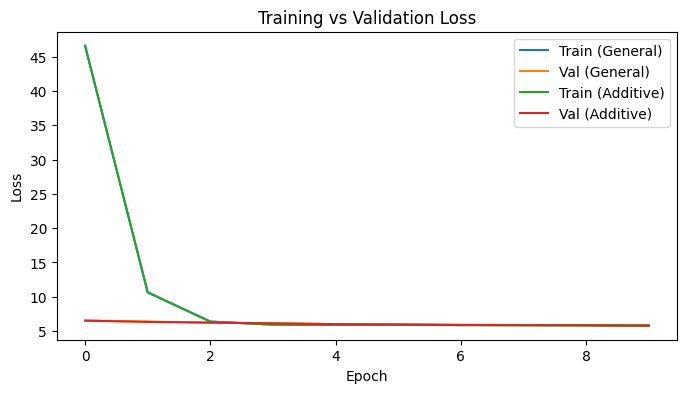

In [145]:
plt.figure(figsize=(8,4))
plt.plot(train_losses_general, label='Train (General)')
plt.plot(valid_losses_general, label='Val (General)')
plt.plot(train_losses_add, label='Train (Additive)')
plt.plot(valid_losses_add, label='Val (Additive)')
plt.legend()
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

### Task 3 — Evaluation & Verification
We compare **General** vs **Additive** attention using:
- Validation loss + perplexity (PPL)
- BLEU score (translation accuracy)
- Average epoch time (efficiency)
- Attention map visualization (interpretability)

In [146]:
# Load best checkpoints for fair evaluation
model_general.load_state_dict(torch.load(os.path.join(MODEL_DIR, "general_best.pt"), map_location=device))
model_additive.load_state_dict(torch.load(os.path.join(MODEL_DIR, "additive_best.pt"), map_location=device))
model_general.eval()
model_additive.eval()

bleu_general = compute_bleu(model_general, val_data)
bleu_additive = compute_bleu(model_additive, val_data)

results_df = pd.DataFrame({
    "Attention": ["General", "Additive"],
    "Train Loss": [train_losses_general[-1], train_losses_add[-1]],
    "Val Loss": [valid_losses_general[-1], valid_losses_add[-1]],
    "Train PPL": [train_ppl_general[-1], train_ppl_add[-1]],
    "Val PPL": [valid_ppl_general[-1], valid_ppl_add[-1]],
    "BLEU (val)": [bleu_general, bleu_additive],
    "Avg Epoch Time (s)": [np.mean(epoch_times_general), np.mean(epoch_times_add)]
})

results_df

,Attention,Train Loss,Val Loss,Train PPL,Val PPL,BLEU (val),Avg Epoch Time (s)
0,General,5.792994,5.831447,327.993524,340.851645,0.026114,1422.853089
1,Additive,5.770688,5.790739,320.758182,327.254841,0.027325,1626.981317


#### Attention Map Visualization
We visualize attention weights to interpret alignments between source and target tokens.

/var/folders/w7/9w9ndzg96hn1rktplwm4434w0000gn/T/ipykernel_29504/219607098.py:18: UserWarning: Glyph 2340 (\N{DEVANAGARI LETTER TA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/w7/9w9ndzg96hn1rktplwm4434w0000gn/T/ipykernel_29504/219607098.py:18: UserWarning: Matplotlib currently does not support Devanagari natively.
  plt.tight_layout()
/var/folders/w7/9w9ndzg96hn1rktplwm4434w0000gn/T/ipykernel_29504/219607098.py:18: UserWarning: Glyph 2375 (\N{DEVANAGARI VOWEL SIGN E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/w7/9w9ndzg96hn1rktplwm4434w0000gn/T/ipykernel_29504/219607098.py:18: UserWarning: Glyph 2357 (\N{DEVANAGARI LETTER VA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/w7/9w9ndzg96hn1rktplwm4434w0000gn/T/ipykernel_29504/219607098.py:18: UserWarning: Glyph 2368 (\N{DEVANAGARI VOWEL SIGN II}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/w7/9w9ndzg96hn1rktplwm4434w0000gn/T/ipykernel_29504/2

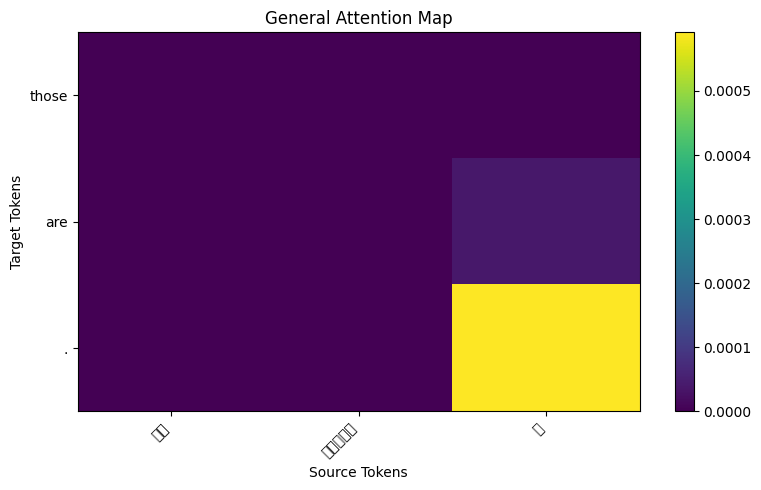

/var/folders/w7/9w9ndzg96hn1rktplwm4434w0000gn/T/ipykernel_29504/219607098.py:18: UserWarning: Glyph 2340 (\N{DEVANAGARI LETTER TA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/w7/9w9ndzg96hn1rktplwm4434w0000gn/T/ipykernel_29504/219607098.py:18: UserWarning: Matplotlib currently does not support Devanagari natively.
  plt.tight_layout()
/var/folders/w7/9w9ndzg96hn1rktplwm4434w0000gn/T/ipykernel_29504/219607098.py:18: UserWarning: Glyph 2375 (\N{DEVANAGARI VOWEL SIGN E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/w7/9w9ndzg96hn1rktplwm4434w0000gn/T/ipykernel_29504/219607098.py:18: UserWarning: Glyph 2357 (\N{DEVANAGARI LETTER VA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/w7/9w9ndzg96hn1rktplwm4434w0000gn/T/ipykernel_29504/219607098.py:18: UserWarning: Glyph 2368 (\N{DEVANAGARI VOWEL SIGN II}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/w7/9w9ndzg96hn1rktplwm4434w0000gn/T/ipykernel_29504/2

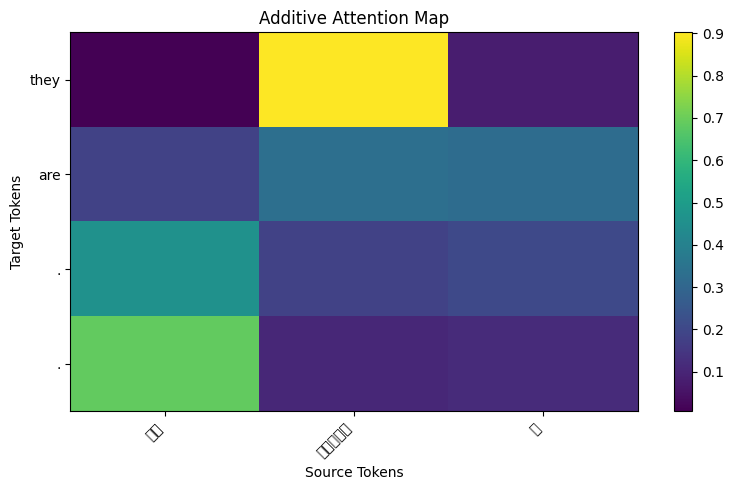

In [147]:
def plot_attention_map(src_sentence, model, title):
    pred_tokens, attn, src_tokens = translate_with_attention(src_sentence, model)
    # Remove special tokens from target for display
    display_trg = [t for t in pred_tokens if t not in ['<sos>', '<eos>', '<pad>']]
    if attn.size == 0:
        print("No attention weights available.")
        return

    # attn shape: (tgt_len, src_len)
    plt.figure(figsize=(8, 5))
    plt.imshow(attn[:len(display_trg), :len(src_tokens)], aspect='auto', cmap='viridis')
    plt.colorbar()
    plt.yticks(range(len(display_trg)), display_trg)
    plt.xticks(range(len(src_tokens)), src_tokens, rotation=45, ha='right')
    plt.title(title)
    plt.xlabel('Source Tokens')
    plt.ylabel('Target Tokens')
    plt.tight_layout()
    plt.show()

sample_sentence = val_data[0]['translation'][SRC_LANGUAGE]
plot_attention_map(sample_sentence, model_general, "General Attention Map")
plot_attention_map(sample_sentence, model_additive, "Additive Attention Map")

#### Results Discussion
- Validation loss is expected to be **lower** than training loss because training uses word dropout and L2 regularization, while validation runs in evaluation mode without noise.
- Compare BLEU scores and epoch times to select the most effective attention mechanism.
- Inspect attention maps to assess whether alignments are reasonable (e.g., monotonic progression and focus on relevant source words).

## Inference

In [96]:
# (Optional) Save final trained checkpoints
torch.save(model_additive.state_dict(), os.path.join(MODEL_DIR, "additive_final.pt"))
torch.save(model_general.state_dict(), os.path.join(MODEL_DIR, "general_final.pt"))

In [98]:
# Load best checkpoints (lowest validation loss)
model_additive.load_state_dict(torch.load(os.path.join(MODEL_DIR, "additive_best.pt"), map_location=device))
model_general.load_state_dict(torch.load(os.path.join(MODEL_DIR, "general_best.pt"), map_location=device))
model_additive.eval()
model_general.eval()

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(26390, 256)
    (rnn): GRU(256, 512)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): GeneralAttention()
    (embedding): Embedding(11905, 256)
    (rnn): GRU(768, 512)
    (fc_out): Linear(in_features=1280, out_features=11905, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [99]:
# Quick inference helper
def translate_text(sentence, model):
    return translate_sentence(sentence, model)